# EMT Dataset: A549_EGF

In [1]:
import os
import numpy as np
import scanpy as sc
import scvelo as scv
import detecting_bifurcations_in_scRNA_seq_data as dbsc

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

### Here we use the standard preprocessing from scanpy

In [2]:
def process_and_save_data(file_path):
    """
        Pre-process the data from a h5ad file using standard Scanpy procedure and saves the pre-processed
        data to a new h5ad file.

        Parameters:
            file_path (str): The full path to the input h5ad file.

        Returns:
            None
    """
    # Check if the input file exists
    if not os.path.isfile(file_path):
        print(f"The input file '{file_path}' does not exist.")
        return

    # Get the filename from the input path
    _, input_filename = os.path.split(file_path)
    filename_without_extension, _ = os.path.splitext(input_filename)
    
    # Create the processed directory path
    processed_dir = '/data/homezvol0/mbarcen1/myrepos/ee282/data/processed/final_project/processed_EMT_tipping_points/'
    
    # Create the directory if it doesn't exist
    os.makedirs(processed_dir, exist_ok=True)

    # Create the processed filename
    processed_filename = f'processed_{filename_without_extension}.h5ad'
    processed_file_path = os.path.join(processed_dir, processed_filename)

    # Check if the processed file already exists
    if os.path.isfile(processed_file_path):
        print(f"The processed file '{processed_file_path}' already exists.")
        return
    
    # Continue with processing the data
    adata = sc.read_h5ad(file_path)

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adata = adata[adata.obs.n_genes_by_counts < 3500, :]
    adata = adata[adata.obs.pct_counts_mt < 10, :]

    sc.pp.normalize_total(adata, target_sum=1e4)
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)

    adata.uns['iroot'] = np.flatnonzero(adata.obs['time'] == '0d')[0]
    sc.tl.dpt(adata)

    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata)
    scv.tl.velocity_graph(adata)

    scv.pp.filter_and_normalize(adata, n_top_genes=50)

    # Save the processed file
    adata.write_h5ad(processed_file_path)
    print(f"Processed data saved to '{processed_file_path}'")

In [3]:
filepath1 = '/data/homezvol0/mbarcen1/myrepos/ee282/data/raw/final_project/Raw Data EMT tipping points/data_01/A549_EGF.h5ad'
process_and_save_data(filepath1)

Filtered out 10734 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/12243 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Extracted 50 highly variable genes.
Processed data saved to '/data/homezvol0/mbarcen1/myrepos/ee282/data/processed/final_project/processed_EMT_tipping_points/processed_A549_EGF.h5ad'


# Stability analysis over pseudotime: 

In [4]:
help(dbsc.tl.traj_inference)

Help on function traj_inference in module detecting_bifurcations_in_scRNA_seq_data.tools.jacobian_inference:

traj_inference(adata, pst_key='dpt_pseudotime', method='Ridge', alpha=1, fit_int=True, width=0.1, inc=0.05, nsim=10, frac=0.9, b=1)
    Perform jacobian inference using the original datapoints without smoothing.
    
    Parameters:
        adata (AnnData): Annotated data object.
        pst_key (str): Key in `adata.obs` representing pseudotime.
        method (str, optional): Regression method. Choose between 'Linear', 'Ridge', or 'Lasso'.
        alpha (float, optional): Regularization coefficient for Ridge and Lasso.
        fit_int (bool, optional): If True, set the fit_intercept parameter to True.
        width (float, optional): Width of pseudotime intervals for inference.
        inc (float, optional): Increment for defining pseudotime intervals.
        nsim (int, optional): Number of simulations for each pseudotime interval.
        frac (float, optional): Fraction of 

In [4]:
adata = sc.read_h5ad('/data/homezvol0/mbarcen1/myrepos/ee282/data/processed/final_project/processed_EMT_tipping_points/processed_A549_EGF.h5ad')
dbsc.tl.traj_inference(adata) #run before plot_stability

Running inference on pseudotime interval: [0.0, 0.1]
Running inference on pseudotime interval: [0.05, 0.15000000000000002]
Running inference on pseudotime interval: [0.1, 0.2]
Running inference on pseudotime interval: [0.15000000000000002, 0.25]
Running inference on pseudotime interval: [0.2, 0.3]
Running inference on pseudotime interval: [0.25, 0.35]
Running inference on pseudotime interval: [0.3, 0.39999999999999997]
Running inference on pseudotime interval: [0.35, 0.44999999999999996]
Running inference on pseudotime interval: [0.39999999999999997, 0.49999999999999994]
Running inference on pseudotime interval: [0.44999999999999996, 0.5499999999999999]
Running inference on pseudotime interval: [0.49999999999999994, 0.6]
Running inference on pseudotime interval: [0.5499999999999999, 0.65]
Running inference on pseudotime interval: [0.6, 0.7000000000000001]
Running inference on pseudotime interval: [0.65, 0.7500000000000001]
Running inference on pseudotime interval: [0.7000000000000001, 

In [6]:
help(dbsc.pl.plot_stability)

Help on function plot_stability in module detecting_bifurcations_in_scRNA_seq_data.plot.grn_inference_pl:

plot_stability(adata, filename_p, rep=1, sizefig=3.54, tick_size=6, axis_size=8, format_file='png', dpi=300)
    Plot stability analysis results.
    
    Parameters:
        adata (AnnData): Annotated data object containing stability analysis results.
        filename_p (str): Output file name and directory (without extension).
        rep (int): Number of repetitions for stability analysis. Default = 1
        sizefig (float): Size of the figure in inches.
        tick_size (int): Font size for tick labels.
        axis_size (int): Font size for axis labels.
        format_file (str): Output file format for saving the plot. (e.g. png, pdf)
        dpi (int): Dots per inch for the figure resolution.
    
    Returns:
        None



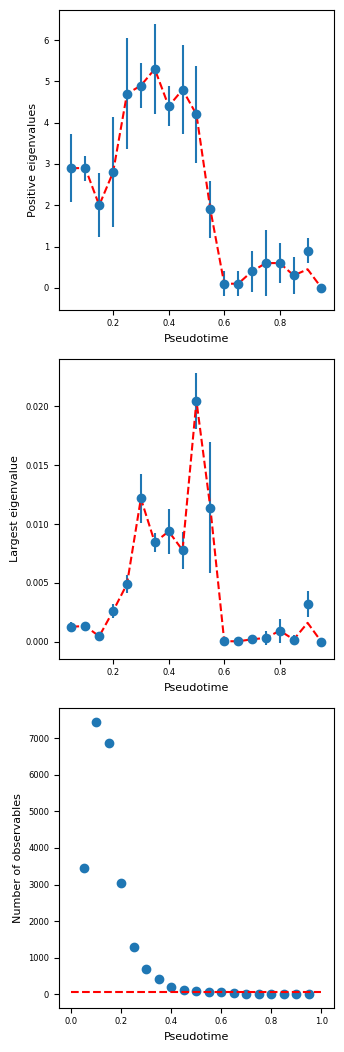

In [5]:
filename1='A549_EGF'
dbsc.pl.plot_stability(adata, filename1) 

# Community Detection

## Create h5ad file for downstream community detection

In [8]:
help(dbsc.tl.create_weights_geneexpress)

Help on function create_weights_geneexpress in module detecting_bifurcations_in_scRNA_seq_data.tools.jacobian_inference:

create_weights_geneexpress(processed_adata, filename, method='Ridge', alpha=1, fit_int=True, width=0.1, inc=0.05, nsim=10, frac=0.9, b=1)
    Create weights for gene expression using functions traj_inference and cell_capture.
    
    Parameters:
        processed_adata (AnnData): Processed annotated data object.
        filename (str): Base filename for saving the resulting data.
        method (str, optional): Regression method. Choose between 'Linear', 'Ridge', or 'Lasso'.
        alpha (float, optional): Regularization coefficient for Ridge and Lasso.
        fit_int (bool, optional): If True, set the fit_intercept parameter to True.
        width (float, optional): Width of pseudotime intervals for inference and cell capture.
        inc (float, optional): Increment for defining pseudotime intervals.
        nsim (int, optional): Number of simulations for each 

In [6]:
filename1 = 'A549_EGF'
adata = sc.read_h5ad('/data/homezvol0/mbarcen1/myrepos/ee282/data/processed/final_project/processed_EMT_tipping_points/processed_A549_EGF.h5ad')
dbsc.tl.create_weights_geneexpress(adata, filename1) 

Running inference on pseudotime interval: [0.0, 0.1]
Running inference on pseudotime interval: [0.05, 0.15000000000000002]
Running inference on pseudotime interval: [0.1, 0.2]
Running inference on pseudotime interval: [0.15000000000000002, 0.25]
Running inference on pseudotime interval: [0.2, 0.3]
Running inference on pseudotime interval: [0.25, 0.35]
Running inference on pseudotime interval: [0.3, 0.39999999999999997]
Running inference on pseudotime interval: [0.35, 0.44999999999999996]
Running inference on pseudotime interval: [0.39999999999999997, 0.49999999999999994]
Running inference on pseudotime interval: [0.44999999999999996, 0.5499999999999999]
Running inference on pseudotime interval: [0.49999999999999994, 0.6]
Running inference on pseudotime interval: [0.5499999999999999, 0.65]
Running inference on pseudotime interval: [0.6, 0.7000000000000001]
Running inference on pseudotime interval: [0.65, 0.7500000000000001]
Running inference on pseudotime interval: [0.7000000000000001, 

## Girvan Newman community detection method

In [10]:
help(dbsc.tl.G_listgen_b)

Help on function G_listgen_b in module detecting_bifurcations_in_scRNA_seq_data.tools.community_detection_algorithms:

G_listgen_b(adata, jac_list, wq=0.9)
    Generate a list of Gene Regulatory Networks (GRNs) with gene expression weights using the grn_geneweight_exp function.
    
    Parameters:
        adata (AnnData): Annotated data matrix.
        jac_list (list): List of Jacobian matrices.
        wq (float, optional): Weight quantile for thresholding edges.
    
    Returns:
        list: List of GRNs with gene expression weights.



In [7]:
filename1 = 'A549_EGF'
adata = sc.read_h5ad(f'gene_exp_{filename1}.h5ad')
jac_list = adata.uns['Jacobian']['jacobians']  # stores range of Jacobians calculated
G_list_1=dbsc.tl.G_listgen_b(adata, jac_list)

In [12]:
help(dbsc.tl.cd_g_w)

Help on function cd_g_w in module detecting_bifurcations_in_scRNA_seq_data.tools.community_detection_algorithms:

cd_g_w(adata, jac_list=None, g_list_method='G_list_gen_b', grn_list=None, most_val_edge=<function between_method at 0x00000266360B9A60>, wq=0.9)
    Detect communities in a graph based on weights of graph using girvan_newman method.
    
    Parameters:
    - adata: AnnData object
    - jac_list: List of Jacobian matrices
    - g_list_method: Method to generate the graph list, choose from ["G_list_gen_b", "G_list_gen_a", "Other"]
    - grn_list: Graph list for "Other" method
    - most_valuable_edge: Edge metric for community detection using betweenness centrality method
    - wq: Weight quantile for graph generation
    
    Returns:
    - Community_list: List of communities detected for each graph
    - Num_com_list: List of the number of communities for each graph



In [8]:
Community_list1, Num_com_list1=dbsc.tl.cd_g_w(adata)

Running cd_g_w: Girvan Newman with edge weights


In [14]:
help(dbsc.pl.plot_comm)

Help on function plot_comm in module detecting_bifurcations_in_scRNA_seq_data.plot.community_pl:

plot_comm(adata, num_com_list, filename_p=None, plot_tick=6, axis_label_size=8, fig_width=3.54, fig_height=3.54, fig_dpi=100, method_key='girvan_newman', grn_type='gene_exp_weights', file_format='png')
    Plot the number of communities over pseudotime.
    
    Parameters:
    - adata (AnnData): Annotated data object containing pseudotime information.
    - num_com_list (list): List of the number of communities corresponding to each pseudotime point.
    - filename_p (str, optional): Output file name and directory (without extension).
    - plot_tick (int): Font size for tick labels.
    - axis_label_size (int): Font size for axis labels.
    - fig_width (float): Width of the figure in inches.
    - fig_height (float): Height of the figure in inches.
    - fig_dpi (int): Dots per inch for the figure resolution.
    - method_key (str): Key representing the community detection method.
    -

Running plot_comm


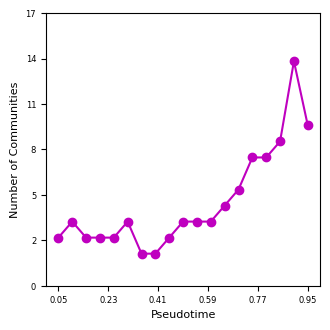

In [9]:
dbsc.pl.plot_comm(adata, Num_com_list1, filename1) # default method key for plot_comm is girvan_newman

## Community detection: Greedy Modularity

In [16]:
help(dbsc.tl.cd_grM_w)

Help on function cd_grM_w in module detecting_bifurcations_in_scRNA_seq_data.tools.community_detection_algorithms:

cd_grM_w(adata, jac_list=None, g_list_method='G_list_gen_b', grn_list=None, wq=0.9)
    Detect communities in gene regulatory networks (GRNs) using weighted greedy modularity optimization.
    
    Parameters:
        adata (AnnData): Annotated data matrix.
        jac_list (list, optional): List of Jacobian matrices. If not provided, it uses the Jacobians stored in `adata`.
        g_list_method (str, optional): Method for generating the graph list. Choices: "G_list_gen_b", "G_list_gen_a", "Other".
        grn_list (list, optional): List of graphs when using "Other" as the graph list generation method.
        wq (float, optional): Weight quantile for generating weighted graphs.
    
    Returns:
        tuple: Tuple containing two lists: `Community_list` (communities detected for each GRN) and `Num_com_list`
        (number of communities detected for each GRN).
    
  

Where "G_list_gen_b" signifies inclusion of mean gene expression into GRN and "G_list_gen_a" does not take this into consideration

In [10]:
Community_list2, Num_com_list2=dbsc.tl.cd_grM_w(adata)

Running plot_comm


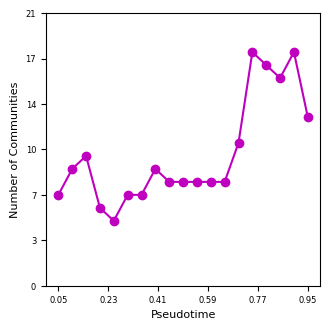

In [11]:
dbsc.pl.plot_comm(adata, Num_com_list2, filename1, method_key='greedy_modularity') 

# Plot both methods on one plot: Figure 6H

In [19]:
help(dbsc.pl.plot_comm_multi)

Help on function plot_comm_multi in module detecting_bifurcations_in_scRNA_seq_data.plot.community_pl:

plot_comm_multi(adata, num_com_list1, num_com_list2, filename_p, plot_tick=6, axis_label_size=8, legend_size=6, fig_width=3.54, fig_height=3.54, fig_dpi=100, method_key1='girvan_newman', method_key2='greedy_modularity', grn_type=None, file_format='pdf')
    Plot the number of communities over pseudotime for two different community detection methods.
    
    Parameters:
    - adata (AnnData): Annotated data object containing pseudotime information.
    - num_com_list1 (list): List of the number of communities corresponding to method_key1.
    - num_com_list2 (list): List of the number of communities corresponding to method_key2.
    - filename_p (str): Output file name (without extension) and directory.
    - plot_tick (int): Font size for tick labels.
    - axis_label_size (int): Font size for axis labels.
    - legend_size (int): Font size for legend.
    - fig_width (float): Width

num_com_list1: [3, 4, 3, 3, 3, 4, 2, 2, 3, 4, 4, 4, 5, 6, 8, 8, 9, 14, 10]
num_com_list2: [7, 9, 10, 6, 5, 7, 7, 9, 8, 8, 8, 8, 8, 11, 18, 17, 16, 18, 13]


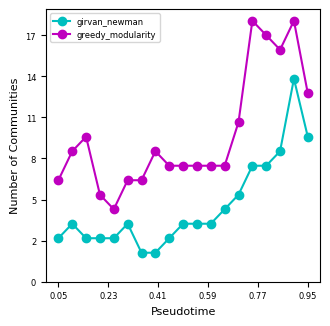

In [12]:
dbsc.pl.plot_comm_multi(adata, Num_com_list1, Num_com_list2, filename1)

## UMAP and Pseudotime

In [2]:
adata = sc.read_h5ad('/data/homezvol0/mbarcen1/myrepos/ee282/data/processed/final_project/processed_EMT_tipping_points/processed_A549_EGF.h5ad')
adata

AnnData object with n_obs × n_vars = 12243 × 50
    obs: 'Clusters', '_X', '_Y', 'batch', 'time', 'cell', 'inducer', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'dpt_pseudotime', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'diffmap_evals', 'iroot', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

### UMAP

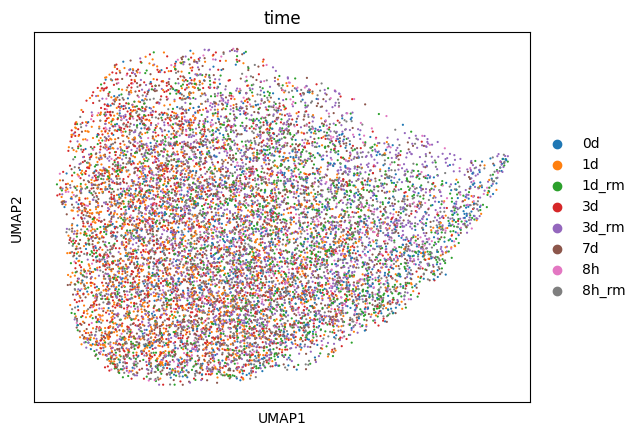

In [3]:
sc.pl.umap(adata, color="time")

### Pseudotime

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


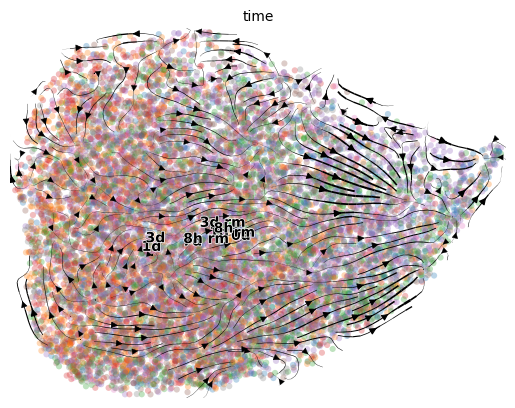

In [4]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color= "time")

## Plot edge weight distribution

In [21]:
help(dbsc.pl.plot_distribution)

Help on function plot_distribution in module detecting_bifurcations_in_scRNA_seq_data.plot.community_pl:

plot_distribution(G_list, filename_p, plot_tick=6, axis_label_size=8, legend_size=4, fig_width=3.54, fig_height=3.54, fig_dpi=100, grn_type=None, xlim_p=None, file_format='png')
    Plot the distribution of edge weights for a list of gene regulatory networks (GRNs).
    
    Parameters:
        G_list (list): A list of networkx graphs representing GRNs.
        filename_p (str): Output file name and directory (without extension).
        plot_tick (int): Font size for tick labels.
        axis_label_size (int): Font size for axis labels.
        legend_size (int): Font size for legend.
        fig_width (float): Width of the figure in inches.
        fig_height (float): Height of the figure in inches.
        fig_dpi (int): Dots per inch for the figure resolution.
        grn_type (str): Type of GRN, if applicable.
        xlim_p (tuple): Tuple specifying the range for the x-axis l

Running plot_distribution


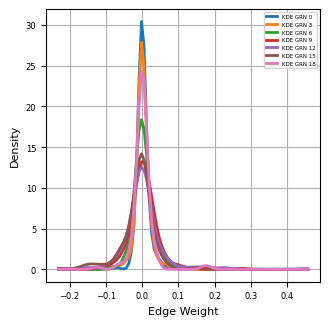

In [13]:
dbsc.pl.plot_distribution(G_list_1, filename1) 

## Where we need to change the x_lim of the plotting function to "zoom in" and view the behavior of the distribution

Running plot_distribution


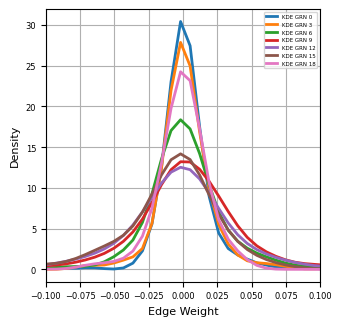

In [14]:
dbsc.pl.plot_distribution(G_list_1, filename1, xlim_p=[-0.1, 0.1]) 